In [1]:
import sys 
import os
import math
import time 
import random
import tracemalloc 
import numpy as np
import pandas as pd 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display, Markdown 

### Lightweight DBMS with B+ Tree Indexing - Report

**Group:** Olympia Track

**Team Members:** Bhanu Repalle, Thumma Ushasree, Saloni Shinde

**Assignment:** Module 4

## 1. Introduction

### Problem Addressed
Efficiently storing and retrieving large amounts of data is a fundamental challenge in computer science. Simple data structures like lists or arrays become inefficient for searching, inserting, or deleting specific records as the dataset grows (often requiring O(n) time complexity). Range queries (finding all records within a certain key range) are also slow in unsorted structures. Database systems, especially those dealing with disk-based storage (though the principle applies to memory), need specialized structures to minimize access time and perform operations quickly.

### Proposed Solution: B+ Tree DBMS
This project implements a lightweight Database Management System (DBMS) in Python. The core of this system relies on the **B+ Tree**, a self-balancing tree data structure optimized for block-based storage and efficient data management.

**Key features of the B+ Tree making it suitable:**
*   **Balanced Structure:** Ensures that all leaf nodes are at the same depth, guaranteeing logarithmic time complexity (O(log n)) for search, insertion, and deletion operations, avoiding worst-case scenarios.
*   **High Fanout:** Internal nodes can store many keys and child pointers, matching well with disk block sizes (reducing I/O in disk-based systems) and creating a wide, shallow tree.
*   **Efficient Range Queries:** All data pointers (or data itself) reside *only* in the leaf nodes, which are linked together sequentially (like a linked list). This allows for very fast retrieval of records within a key range by finding the start leaf and following the links.

This report details the implementation of the B+ Tree and its associated operations, followed by a performance analysis comparing it to a brute-force approach, and concludes with examples of its visualization.

## 2. Implementation

This section describes the core components and algorithms used in the B+ Tree implementation (`bplustree.py`).

We will first set up imports and a helper function for visualization used in the subsequent demonstration cells.

### B+ Tree Node (`BPlusTreeNode`)

The fundamental building block is the `BPlusTreeNode`. A single class is used for both internal and leaf nodes, differentiated by an `is_leaf` boolean flag.

*   **`order`**: An integer defining the maximum capacity of the node (specifically, max children for internal nodes, related to max keys).
*   **`is_leaf`**: Boolean flag (`True` for leaf nodes, `False` for internal nodes).
*   **`keys`**: A sorted list of keys stored in the node. Max keys = `order - 1`.
*   **`values`**: A list whose content depends on `is_leaf`:
    *   If `is_leaf=True`: Stores the actual data values associated with the keys. `len(values)` == `len(keys)`.
    *   If `is_leaf=False`: Stores references (pointers) to child `BPlusTreeNode` objects. `len(values)` == `len(keys) + 1`.
*   **`parent`**: A reference to the parent node (None for the root). Essential for splitting and merging operations.
*   **`next_leaf`**: A reference to the next leaf node in sequence (None for internal nodes or the last leaf). Used for efficient range queries.

Helper methods like `is_full()` and `is_underflow()` check if the node has reached its maximum or fallen below its minimum key capacity, respectively.

In [2]:
try:
    import graphviz
    from database.table import Table 
    from database.db_manager import DatabaseManager
    from database.performance import PerformanceAnalyzer
    from database.bplustree import BPlusTree, BPlusTreeNode
except ModuleNotFoundError as e:
    print(f"Error importing database modules: {e}")
    raise
except ImportError:
     print("Graphviz library not found (pip install graphviz). Visualization will be skipped.")
     graphviz = None

# --- Helper function for visualization ---
def visualize_and_display(tree, title="B+ Tree State"):
    """Generates and displays the tree visualization."""
    display(Markdown(f"#### {title}")) # Smaller heading for steps
    if not graphviz:
        print("Skipping visualization (graphviz not installed).")
        return

    dot = tree.visualize_tree()
    if dot:
        try:
            svg_data = dot.pipe(format='svg').decode('utf-8')
            display(SVG(svg_data)) # Display SVG in output
        except graphviz.backend.execute.ExecutableNotFound:
             print("\nERROR: Graphviz executable not found in PATH.")
        except Exception as e:
             print(f"\nAn error occurred during visualization rendering: {e}")
    else:
        print("Visualization object could not be created.")

print("Setup complete.")

Setup complete.


### 1. Insertion Operation Demonstration (`insert`, `_split_node`, `_insert_in_parent`)

This sequence demonstrates the insertion process and how the tree dynamically restructures itself through splits when nodes become full. We use `order=4` (max 3 keys/node, min 1 key/node).

1.  **Initial Inserts:** Keys `[10, 20, 5]` are inserted into the initial empty root leaf node. The node becomes `[5, 10, 20]` which is now full (max capacity reached).
2.  **Leaf Split & New Root:** Inserting `15` causes the leaf `[5, 10, 20]` to overflow (conceptual `[5, 10, 15, 20]`).
    *   `_split_node` divides it into `[5, 10]` and `[15, 20]`.
    *   The first key of the new right sibling (`15`) is copied up.
    *   Since the split node was the root, `_insert_in_parent` creates a new internal root `[15]` pointing to the two leaves. Tree height becomes 2.
3.  **Simple Insert:** Inserting `25` finds the correct leaf (`[15, 20]`) and adds the key, making it `[15, 20, 25]`. This leaf is now full.
4.  **Leaf Split & Parent Update:** Inserting `40` finds the leaf `[15, 20, 25]`. It overflows (`[15, 20, 25, 40]`).
    *   `_split_node` divides it into `[15, 20]` and `[25, 40]`.
    *   The first key of the new right sibling (`25`) is copied up.
    *   `_insert_in_parent` adds key `25` and the pointer to the new leaf into the existing root `[15]`. The root becomes `[15, 25]`. The root is now full but does not split yet.

--- Scenario 1: Insertions and Splits ---
(Using order=4, min_keys=1)


####  Initial Empty Tree

#### 1.1: After inserting [10, 20, 5] (Leaf Full)

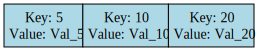

#### 1.2: After inserting 15 (Triggers Leaf Split -> New Root)...

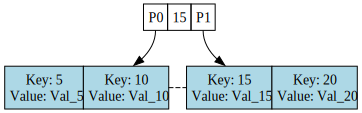

#### 1.3: After inserting [25] (Right Leaf Full)

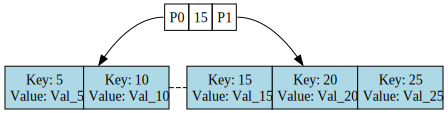

#### 1.4: After inserting 40 (Parent Split)

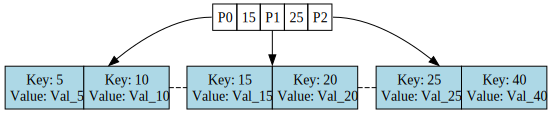

In [3]:
# --- Initialize Tree for Scenario 1 ---
print("--- Scenario 1: Insertions and Splits ---")
print(f"(Using order=4, min_keys=1)")
tree1 = BPlusTree(order=4)
visualize_and_display(tree1, " Initial Empty Tree")

# 1a. Insert first few keys (fill leaf)
keys1 = [10, 20, 5]
for k in keys1: tree1.insert(k, f"Val_{k}")
visualize_and_display(tree1, "1.1: After inserting [10, 20, 5] (Leaf Full)")

# 1b. Trigger first leaf split & new root
key_split1 = 15
tree1.insert(key_split1, f"Val_{key_split1}")
visualize_and_display(tree1, f"1.2: After inserting {key_split1} (Triggers Leaf Split -> New Root)...")

# 1c. Insert to cause second leaf split (updating parent)
keys2 = [25] 
for k in keys2: tree1.insert(k, f"Val_{k}")
visualize_and_display(tree1, f"1.3: After inserting {keys2} (Right Leaf Full)")

# 1d. Insert to cause internal split
keys3 = 40 
tree1.insert(keys3, f"Val_{keys3}")
visualize_and_display(tree1, f"1.4: After inserting {keys3} (Parent Split)")

### 2. Deletion Operation Demonstration (`delete`, `_handle_underflow`, `_borrow_...`)

This sequence demonstrates deletion scenarios, including simple deletion and rebalancing using borrowing. We use `order=4` (min 1 key/node).

1.  **Initial State:** We start by inserting keys `[10, 20, 5, 15, 25]` to create a tree. The resulting state is: Root `[15]`, Leaves `[5, 10]`, `[15, 20, 25]`.
2.  **Simple Deletion:** Key `25` is deleted from leaf `[15, 20, 25]`.
    *   The leaf becomes `[15, 20]`.
    *   It still contains 2 keys (>= minimum 1), so no underflow occurs and no rebalancing is needed.
3.  **Prepare for Borrow:** Key `10` is deleted from leaf `[5, 10]`.
    *   The leaf becomes `[5]`.
    *   It contains 1 key (>= minimum 1), so no underflow occurs yet. This step leaves the node at its minimum size, setting up the next deletion.
4.  **Deletion Causing Borrow from Right:** Key `5` is deleted from leaf `[5]`.
    *   The leaf becomes `[]`, causing underflow (0 keys < minimum 1). `_handle_underflow` is called.
    *   The implementation checks siblings. Left sibling: None. Right sibling: `[15, 20]`.
    *   The right sibling has 2 keys (> minimum 1), so it **can lend**.
    *   `_borrow_from_right` executes:
        *   The first key/value (`15`, `Val_15`) is moved from the right sibling `[15, 20]` to the underflowing node `[]`. The node becomes `[15]`.
        *   The right sibling becomes `[20]`.
        *   The separator key in the parent `[15]` (which is key `15` itself) is updated to become the *new* first key of the right sibling (`20`). The parent (root) becomes `[20]`.
    *   The tree is rebalanced.

--- Scenario 2: Simple Delete & Borrow Right ---

Inserting [10, 20, 5, 15, 25]...


#### 2.1: Initial State for Deletion

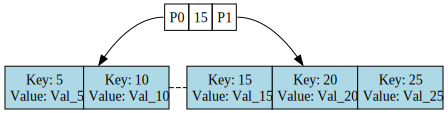

#### 2.2: After deleting 25 (Simple case)...

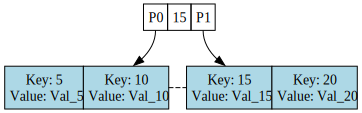

#### 2.3 Intermediate after deleting 10 (Before Borrow)

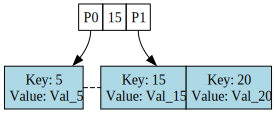

#### 2.4: After deleting 5 (Borrowed from Right and update parent)

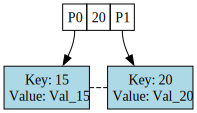

In [4]:
# --- Initialize Tree for Scenario 2 ---
print("--- Scenario 2: Simple Delete & Borrow Right ---")
tree2 = BPlusTree(order=4)
keys = [10, 20, 5, 15, 25] 
print(f"\nInserting {keys}...")
for k in keys: tree2.insert(k, f"Val_{k}")
visualize_and_display(tree2, "2.1: Initial State for Deletion")

# 2a. Simple Delete
key_del_simple = 25
deleted = tree2.delete(key_del_simple); 
visualize_and_display(tree2, f"2.2: After deleting {key_del_simple} (Simple case)...")

# 2b. Delete causing underflow and borrow Right
key_del_borrow = 10
deleted = tree2.delete(key_del_borrow)
visualize_and_display(tree2, f"2.3 Intermediate after deleting {key_del_borrow} (Before Borrow)")

key_del_borrow2 = 5
deleted = tree2.delete(key_del_borrow2)
visualize_and_display(tree2, f"2.4: After deleting {key_del_borrow2} (Borrowed from Right and update parent)")

### 3. Scenario: Borrow from Left Sibling (`delete`, `_handle_underflow`, `_borrow_from_right`)

This sequence demonstrates a case where deletion causes underflow, and the node borrows from its **right** sibling. We use `order=4` (min 1 key/node).

1.  **Initial State:** Insert keys `[10, 20, 5, 15]`. This creates Root `[15]`, Leaves `[5, 10]`, `[15, 20]`.
2.  **Delete `20`:** Key `20` is deleted from leaf `[15, 20]`.
    *   The leaf becomes `[15]`.
    *   It contains 1 key (>= minimum 1), so no underflow occurs.
3.  **Delete `15` (Causes Underflow & Borrow):** Key `15` is deleted from leaf `[15]`.
    *   The leaf becomes `[]`, causing underflow (0 keys < minimum 1). `_handle_underflow` is called.
    *   Parent is Root `[15]`. Node `[]` is child index 1.
    *   Checks Left Sibling `[5, 10]` (Index 0). Has 2 keys (> min 1). **Can borrow left.**
    *   Checks Right Sibling: None exists.
    *   The implementation prioritizes borrowing from the **left** if possible. `_borrow_from_left` executes:
        *   Parent separator key at index `1-1=0` is `15`. Key `15` moves down to node `[]` -> `[15]`.
        *   Last key `10` from left sibling `[5, 10]` moves up to replace parent key `15`. Parent becomes `[10]`.
        *   Left sibling becomes `[5]`.
    *   **Result:** Tree is rebalanced. Root `[10]`, Leaves `[5]`, `[15]`.

--- Scenario 3: Borrow Left ---

Inserting [10, 20, 5, 15]...


#### 3.1: Initial State for Deletion

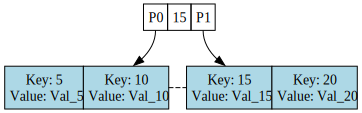

#### 3.3: After deleting 20

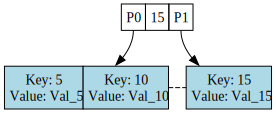

#### 3.3: After deleting 15 (Borrowed from Left and update parent)

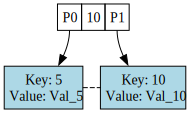

In [5]:
# --- Initialize Tree for Scenario 3 ---
print("--- Scenario 3: Borrow Left ---")
tree3 = BPlusTree(order=4)
keys = [10, 20, 5, 15] 
print(f"\nInserting {keys}...")
for k in keys: tree3.insert(k, f"Val_{k}")
visualize_and_display(tree3, "3.1: Initial State for Deletion")

# 3a. Delete causing underflow and borrow Left
key_del_borrow = 20
deleted = tree3.delete(key_del_borrow)
visualize_and_display(tree3, f"3.3: After deleting {key_del_borrow}")

key_del_borrow2 = 15
deleted = tree3.delete(key_del_borrow2)
visualize_and_display(tree3, f"3.3: After deleting {key_del_borrow2} (Borrowed from Left and update parent)")

### 3(b). Deletion Scenario: Borrow from Left Sibling (Revised Setup)

This sequence aims to reliably demonstrate borrowing from the **left** sibling. We use `order=4` (min 1 key/node).

1.  **Initial State:** Insert keys `[10, 20, 30, 5, 15, 18]`. Let's trace this:
    *   `10, 20, 30` -> `[10, 20, 30]` (Full)
    *   `5` -> `[5, 10, 20, 30]` -> Split -> Root `[20]`, Leaves `[5, 10]`, `[20, 30]`
    *   `15` -> Insert into `[5, 10]` -> `[5, 10, 15]` (Full)
    *   `18` -> Insert into `[5, 10, 15]` -> `[5, 10, 15, 18]` -> Split -> Root `[15, 20]`, Leaves `[5, 10]`, `[15, 18]`, `[20, 30]`
    *   **Initial state is Root `[15, 20]`, Leaves `[5, 10]`, `[15, 18]`, `[20, 30]`**.
2.  **Delete `18`:** Key `18` deleted from `[15, 18]`. Leaf becomes `[15]` (Min keys). No underflow.
3.  **Delete `15` (Causes Underflow & Borrow):** Key `15` deleted from `[15]`.
    *   Leaf becomes `[]`, causing underflow. `_handle_underflow` called.
    *   Parent is Root `[15, 20]`. Node `[]` is child index 1.
    *   Checks Left Sibling `[5, 10]` (Index 0). Has 2 keys (> min 1). **Can borrow left.**
    *   Checks Right Sibling `[20, 30]` (Index 2). Has 2 keys (> min 1). **Can borrow right.**
    *   Implementation checks Left first and succeeds. `_borrow_from_left` executes:
        *   Parent separator key at index `1-1=0` is `15`. Key `15` moves down to `[]` -> `[15]`.
        *   Last key `10` from left sibling `[5, 10]` moves up to replace parent key `15`. Parent becomes `[10, 20]`.
        *   Left sibling becomes `[5]`.
    *   **Result:** Tree is rebalanced. Root `[10, 20]`, Leaves `[5]`, `[15]`, `[20, 30]`.

--- Scenario 3b: Borrow Left ---

Inserting [10, 20, 30, 5, 15, 18]...


#### 3(b).1: Initial State for Deletion

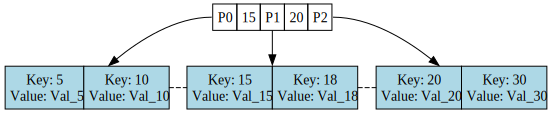

#### 3(b).2 After deleting 18 (Siblings at Min)

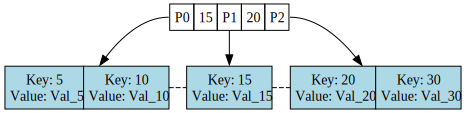

#### 3(b).3 After deleting 15, Underflow occurs (Borrowed from Left)

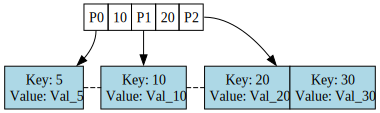

In [6]:
# --- Initialize Tree for Borrow Left Demo ---
print("--- Scenario 3b: Borrow Left ---")
tree_borrow_left = BPlusTree(order=4)
keys_setup = [10, 20, 30, 5, 15, 18] 
print(f"\nInserting {keys_setup}...")
for k in keys_setup: tree_borrow_left.insert(k, f"Val_{k}")
visualize_and_display(tree_borrow_left, "3(b).1: Initial State for Deletion")

# Delete keys from middle node until underflow
key_del_1 = 18
deleted = tree_borrow_left.delete(key_del_1)
visualize_and_display(tree_borrow_left, f"3(b).2 After deleting {key_del_1} (Siblings at Min)")

key_del_2 = 15
deleted = tree_borrow_left.delete(key_del_2)
visualize_and_display(tree_borrow_left, f"3(b).3 After deleting {key_del_2}, Underflow occurs (Borrowed from Left)")

### 4. Deletion Scenario: Merging Leaf Nodes (Order 4)

This sequence demonstrates a deletion causing underflow where neither sibling can lend (both are at minimum capacity), forcing a **merge** of leaf nodes. We use `order=4` (min 1 key/node).

1.  **Setup State:** First, insert keys `[10, 20, 5, 15, 25, 30]`.
2.  **Make sibiling nodes min:**Then delete keys `[5, 20, 30]` using `**delete()**` multiple times. State before merge trigger (`4.2`) is Root `[15, 25]`, Leaves `[10]`, `[15]`, `[25]`.
3.  **Delete `15` (Triggers Merge):** Call to `**delete(15)**`. Deleting key `15` from leaf `[15]` causes underflow (`[]`). `delete` calls `**_handle_underflow**` on `[]`.
    *   `**_handle_underflow**` called for `[]` (child index 1 of root `[15, 25]`).
    *   Checks Left Sibling `[10]` (index 0). Has 1 key (minimum). Cannot borrow.
    *   Checks Right Sibling `[25]` (index 2). Has 1 key (minimum). Cannot borrow.
    *   Merge is required. `**_handle_underflow**` calls `**_merge_nodes**`. Assume implementation merges the underflowing node `[]` into its left sibling `[10]`.
    *   `**_merge_nodes(left=[10], right=[], parent=[15, 25], left_node_idx=0)` executes:
        *   Separator key `15` removed from parent `[15, 25]`. Parent becomes `[25]`.
        *   Pointer to `[]` (at index 1) removed from parent values.
        *   Keys/values from `[]` added to `[10]`. Merged leaf remains `[10]`.
        *   `next_leaf` of `[10]` updated to point to `[25]`.
    *   Parent `[25]` (the root) has 1 key and 2 children (`[10]`, `[25]`). It does not underflow.
    *   **Result:** The merge is successful, and the parent is updated. Tree height remains the same. Final state shown in `4.3`.

--- Scenario 4: Merge Leaves & Root Change ---


#### 4.1: Initial State for Merge Demo

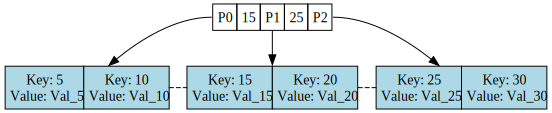


Deleting keys [5, 20, 30] to set up minimum leaves...


#### 4.2: State before Merge Trigger (Siblings at Min)

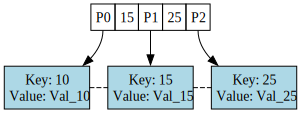

#### 4.3: State After Deleting 15 (Merge Occurred)

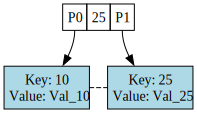

In [7]:
# --- Initialize Tree for Scenario 4 ---
print("--- Scenario 4: Merge Leaves & Root Change ---")
tree4 = BPlusTree(order=4)
keys_ins = [10, 20, 5, 15, 25, 30] 
for k in keys_ins: tree4.insert(k, f"Val_{k}")
visualize_and_display(tree4, f"4.1: Initial State for Merge Demo")

keys_del_setup = [5, 20, 30] 
print(f"\nDeleting keys {keys_del_setup} to set up minimum leaves...")
for k in keys_del_setup:
    deleted = tree4.delete(k)
visualize_and_display(tree4, "4.2: State before Merge Trigger (Siblings at Min)")

# Delete key causing underflow where siblings cannot lend
key_del_merge = 15
deleted = tree4.delete(key_del_merge)
visualize_and_display(tree4, f"4.3: State After Deleting {key_del_merge} (Merge Occurred)")

### 4(b). Deletion Scenario: Merging Leaf Nodes (Order 5 - Explicit Result)

This sequence uses `order=5` (min 2 keys/node) to make the result of the merge more visually distinct. It demonstrates deletion causing underflow where neighbors cannot lend, forcing a merge.

1.  **Setup State:** Insert keys `[10, 20, 30, 5, 15, 25, 35]`. State shown in `4(b).1`.
2.  **Prepare for Merge:** Delete key `25` using `**delete(25)**`. Leaf `[25, 30, 35]` becomes `[30, 35]` (min 2 keys). State before merge trigger shown in `4(b).2`.
3.  **Delete `15` (Triggers Merge):** Call to `**delete(15)**`. Deleting key `15` from leaf `[15, 20]` causes underflow (`[20]`, 1 key < min 2). `delete` calls `**_handle_underflow**` on `[20]`.
    *   `**_handle_underflow**` called for `[20]` (child index 1 of root `[15, 25]`).
    *   Checks Left Sibling `[5, 10]` (Index 0). Has 2 keys (minimum). Cannot borrow.
    *   Checks Right Sibling `[30, 35]` (Index 2). Has 2 keys (minimum). Cannot borrow.
    *   Merge required. `**_handle_underflow**` calls `**_merge_nodes**`. Merges underflowing node `[20]` into its left sibling `[5, 10]`.
    *   `**_merge_nodes(left=[5, 10], right=[20], parent=[15, 25], left_node_idx=0)` executes:
        *   Separator key `15` removed from parent `[15, 25]`. Parent becomes `[25]`.
        *   Pointer to `[20]` (at index 1) removed from parent values.
        *   Keys/values from `[20]` added to `[5, 10]`. Merged leaf becomes `[5, 10, 20]`.
        *   `next_leaf` updated.
    *   Parent `[25]` (the root) has 1 key and 2 children (`[5, 10, 20]`, `[30, 35]`). It does not underflow (root min keys = 1).
    *   **Result:** The merge is successful. The merged leaf `[5, 10, 20]` clearly shows keys from both original nodes. Final state shown in `4(b).3`.

--- Scenario 4b: Merge Leaves (Order 5) for explicitly noticing merge ---
(Using order=5, min_keys=2)

Setting up state for Merge Demo (order=5)...


#### 4(b).1: State after initial insertions

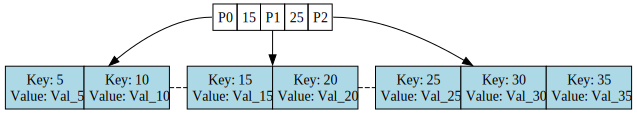

#### 4(b).2: State before Merge Trigger After Deleting 25 (Siblings at Min)

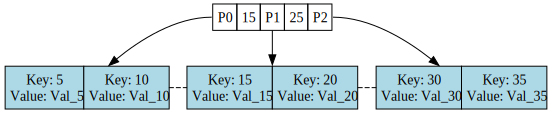

#### 4(b).3: State After Deleting 15 (Merge Occurred)

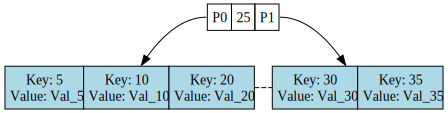

In [8]:
# --- Initialize Tree for Scenario 4b ---
print("--- Scenario 4b: Merge Leaves (Order 5) for explicitly noticing merge ---")
new_order = 5
tree4 = BPlusTree(order=new_order)
print(f"(Using order={new_order}, min_keys={math.ceil(new_order / 2) - 1})")

print("\nSetting up state for Merge Demo (order=5)...")
keys_ins = [10, 20, 30, 5, 15, 25, 35]
for k in keys_ins: tree4.insert(k, f"Val_{k}")
visualize_and_display(tree4, "4(b).1: State after initial insertions")

# Delete keys to leave relevant siblings at minimum (2 keys)
key_del_merge = 25
deleted = tree4.delete(key_del_merge)
visualize_and_display(tree4, f"4(b).2: State before Merge Trigger After Deleting {key_del_merge} (Siblings at Min)")

# Delete key causing underflow where siblings cannot lend
key_del_merge2 = 15
deleted = tree4.delete(key_del_merge2)
visualize_and_display(tree4, f"4(b).3: State After Deleting {key_del_merge2} (Merge Occurred)")

## 4. Visualization
Demonstration of Populated Table, Persistence, and Queries

This section demonstrates the complete workflow using the `EquipmentLog` and `Equipment` table from our project schema. It involves:
1.  Populating the table with a sufficient number of records (20+).
2.  Visualizing the final B+ Tree structure.
3.  Saving the database state to disk (Persistence).
4.  Loading the database state into a new manager instance.
5.  Verifying the loaded data via visualization, search (`get`), and range query.

In [9]:
# --- Visualization Helper ---
def visualize_and_display(tree, title="B+ Tree State"):
    display(Markdown(f"#### {title}"))
    if not graphviz: print("Skipping visualization."); return
    if tree is None or not hasattr(tree, 'visualize_tree'): print("Invalid object for visualization."); return
    dot = tree.visualize_tree()
    if dot:
        try: svg_data = dot.pipe(format='svg').decode('utf-8'); display(SVG(svg_data))
        except graphviz.backend.execute.ExecutableNotFound: print("ERROR: Graphviz executable not found.")
        except Exception as e: print(f"ERROR during visualization: {e}")
    else: print("Visualization object not created.")
    display(Markdown("---"))

# --- Data Generation Helper (Modified for Equipment) ---
def generate_equipment_data(start_id, count, existing_ids):
    """Generates additional unique Equipment records."""
    data = []
    current_id = start_id
    names = ["Gloves", "Helmet", "Pads", "Skates", "Stick", "Goal", "Marker Cones", "Whistle", "Stopwatch", "Clipboard", "First Aid Kit", "Water Bottles", "Shin Guards", "Elbow Pads", "Knee Pads"]
    conditions = ["Good", "Fair", "Poor"]
    date_counter = 0
    while len(data) < count:
        if current_id not in existing_ids:
            day = 5 + date_counter
            month = random.randint(1, 4)
            year = random.randint(2023, 2024)
            last_checked = f"{year}-{month:02d}-{day:02d}"
            rec = {
                "EquipmentID": current_id,
                "EquipmentName": f"{random.choice(names)} #{current_id}",
                "IsAvailable": random.choice([True, False]),
                "Condition_": random.choice(conditions),
                "LastCheckedDate": last_checked
            }
            data.append(rec)
            existing_ids.add(current_id)
            date_counter += 1
        current_id += 1
        if current_id > start_id + count * 2: break # Safety break
    return data

def generate_log_data(start_id, count, existing_ids, valid_equipment_ids):
    """Generates additional unique EquipmentLog records using valid EquipmentIDs."""
    log_data = []
    current_id = start_id
    member_ids = [501, 502, 503, 504, 505, 506, 507, 508, 509, 510] # More members
    date_counter = 0
    while len(log_data) < count:
        if current_id not in existing_ids:
            day = 15 + date_counter # Start generating dates after original samples
            issue_date = f"2024-04-{day:02d} {random.randint(9,16):02d}:{random.randint(0,59):02d}:00"
            return_date = ""
            if random.random() > 0.4: # Some are returned
                 return_day = day + random.randint(0, 3)
                 # Handle month rollover possibility for simplicity
                 return_day = min(return_day, 30)
                 return_date = f"2024-04-{return_day:02d} {random.randint(9,17):02d}:{random.randint(0,59):02d}:00"
            # Ensure we use an EquipmentID that actually exists in our generated set
            equip_id = random.choice(valid_equipment_ids)
            rec = {
                "LogID": current_id,
                "EquipmentID": equip_id, # Use existing ID
                "IssuedTo": random.choice(member_ids),
                "IssueDate": issue_date,
                "ReturnDate": return_date
            }
            log_data.append(rec)
            existing_ids.add(current_id)
            date_counter += 1
        current_id += 1
        if current_id > start_id + count * 2: break # Safety break
    return log_data


print("Setup for Final Demo Complete.")

Setup for Final Demo Complete.


In [10]:
# Schemas
equipment_schema = {
    "EquipmentID": int,    # Search Key
    "EquipmentName": str,
    "IsAvailable": bool,
    "Condition_": str,
    "LastCheckedDate": str
}

equipment_log_schema = {
    "LogID": int,         # Search Key
    "EquipmentID": int,
    "IssuedTo": int,
    "IssueDate": str,
    "ReturnDate": str
}

# --- Generate Data (Aim for ~25 records each) ---
TARGET_RECORDS = 25

# Equipment Data
equipment_data_initial = [
    {"EquipmentID": 1, "EquipmentName": "Football", "IsAvailable": True, "Condition_": "Good", "LastCheckedDate": "2024-01-10"},
    {"EquipmentID": 5, "EquipmentName": "Basket Hoop", "IsAvailable": False, "Condition_": "Fair", "LastCheckedDate": "2024-03-15"},
    {"EquipmentID": 3, "EquipmentName": "Tennis Racket", "IsAvailable": True, "Condition_": "Good", "LastCheckedDate": "2024-04-01"},
    {"EquipmentID": 8, "EquipmentName": "Volleyball Net", "IsAvailable": True, "Condition_": "Good", "LastCheckedDate": "2024-02-20"},
    {"EquipmentID": 2, "EquipmentName": "Cricket Bat", "IsAvailable": True, "Condition_": "Poor", "LastCheckedDate": "2023-11-05"},
    {"EquipmentID": 6, "EquipmentName": "Badminton Set", "IsAvailable": False, "Condition_": "Good", "LastCheckedDate": "2024-04-10"}
]
existing_eq_ids = set(d["EquipmentID"] for d in equipment_data_initial)
eq_needed = TARGET_RECORDS - len(equipment_data_initial)
eq_data_generated = generate_equipment_data(max(existing_eq_ids)+1, eq_needed, existing_eq_ids)
all_equipment_data = equipment_data_initial + eq_data_generated
all_equipment_ids = list(existing_eq_ids.union(set(d["EquipmentID"] for d in eq_data_generated))) # Get all valid IDs

print(f"Total Equipment records prepared: {len(all_equipment_data)}")

# EquipmentLog Data
log_data_initial = [
    {"LogID": 1001, "EquipmentID": 1, "IssuedTo": 501, "IssueDate": "2024-04-10 09:00:00", "ReturnDate": ""},
    {"LogID": 1005, "EquipmentID": 3, "IssuedTo": 501, "IssueDate": "2024-04-10 11:00:00", "ReturnDate": ""},
    {"LogID": 1002, "EquipmentID": 5, "IssuedTo": 502, "IssueDate": "2024-04-11 10:30:00", "ReturnDate": "2024-04-11 15:00:00"},
    {"LogID": 1004, "EquipmentID": 8, "IssuedTo": 503, "IssueDate": "2024-04-12 09:30:00", "ReturnDate": ""},
    {"LogID": 1003, "EquipmentID": 1, "IssuedTo": 503, "IssueDate": "2024-04-12 11:00:00", "ReturnDate": ""},
    {"LogID": 1006, "EquipmentID": 2, "IssuedTo": 504, "IssueDate": "2024-04-13 14:00:00", "ReturnDate": ""},
    {"LogID": 1008, "EquipmentID": 6, "IssuedTo": 502, "IssueDate": "2024-04-14 10:30:00", "ReturnDate": "2024-04-16 15:00:00"},
    {"LogID": 1010, "EquipmentID": 5, "IssuedTo": 505, "IssueDate": "2024-04-15 10:30:00", "ReturnDate": "2024-04-16 15:00:00"},
]
existing_log_ids = set(d["LogID"] for d in log_data_initial)
log_needed = TARGET_RECORDS - len(log_data_initial)
# Use max existing LogID + 1 to avoid collision if initial IDs aren't sequential
log_data_generated = generate_log_data(max(existing_log_ids)+1 if existing_log_ids else 1011, log_needed, existing_log_ids, all_equipment_ids)
all_log_data = log_data_initial + log_data_generated

print(f"Total EquipmentLog records prepared: {len(all_log_data)}")
# Shuffle data for more realistic insertion order
random.shuffle(all_equipment_data)
random.shuffle(all_log_data)

Total Equipment records prepared: 25
Total EquipmentLog records prepared: 25


Database Manager initialized.

Creating Database 'Sports_Management'...
Database 'Sports_Management' created successfully.
Creating Table 'Equipment' (Order=5)...
Table 'Equipment' created with search key 'EquipmentID'.
Table 'Equipment' created in database 'Sports_Management'.
Creating Table 'EquipmentLog' (Order=5)...
Table 'EquipmentLog' created with search key 'LogID'.
Table 'EquipmentLog' created in database 'Sports_Management'.

Inserting 25 records into 'Equipment'...


Inserting Equipment:   0%|          | 0/25 [00:00<?, ?it/s]


Inserting 25 records into 'EquipmentLog'...


Inserting EquipmentLog:   0%|          | 0/25 [00:00<?, ?it/s]

All records inserted.


### Visualization of Populated Tables (Before Saving)

--- Equipment Table ---

#### Equipment B+ Tree Structure

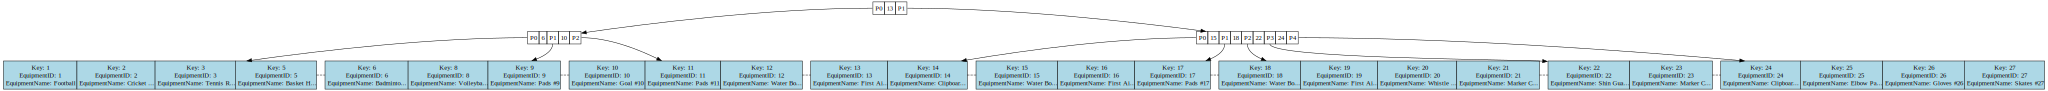

---

--- EquipmentLog Table ---

#### EquipmentLog B+ Tree Structure

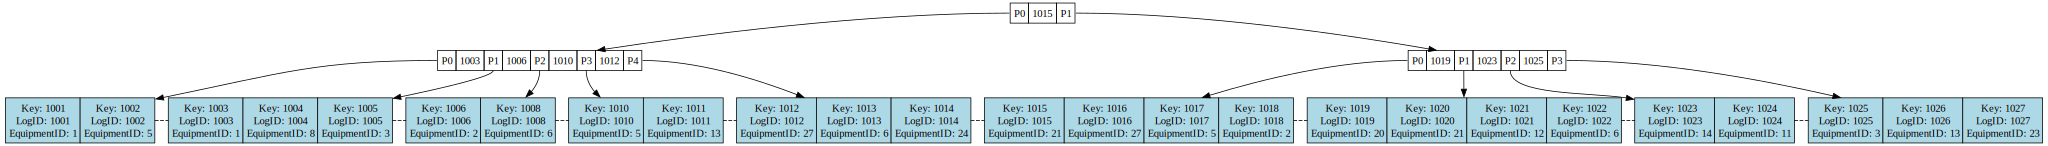

---

Note: Leaf nodes show Key and partial record data ('FieldName: Value').

In [11]:
# --- Part 1: Create DB, Tables, Insert Data ---
db_manager_save = DatabaseManager()
DB_NAME = "Sports_Management" # Use specified name
TABLE_EQ = "Equipment"
TABLE_LOG = "EquipmentLog"
TREE_ORDER = 5 # Chosen order

print(f"\nCreating Database '{DB_NAME}'...")
msg, success = db_manager_save.create_database(DB_NAME)
assert success, f"DB creation failed: {msg}"

print(f"Creating Table '{TABLE_EQ}' (Order={TREE_ORDER})...")
msg, success = db_manager_save.create_table(DB_NAME, TABLE_EQ, equipment_schema, order=TREE_ORDER, search_key='EquipmentID')
assert success, f"Table creation failed: {msg}"

print(f"Creating Table '{TABLE_LOG}' (Order={TREE_ORDER})...")
msg, success = db_manager_save.create_table(DB_NAME, TABLE_LOG, equipment_log_schema, order=TREE_ORDER, search_key='LogID')
assert success, f"Table creation failed: {msg}"

# Get table instances
eq_table_save, success_eq = db_manager_save.get_table(DB_NAME, TABLE_EQ)
log_table_save, success_log = db_manager_save.get_table(DB_NAME, TABLE_LOG)
assert success_eq and success_log, "Failed to get table instances"

print(f"\nInserting {len(all_equipment_data)} records into '{TABLE_EQ}'...")
insertion_errors_eq = 0
for record in tqdm(all_equipment_data, desc="Inserting Equipment"): 
    success, msg = eq_table_save.insert(record)
    if not success:
        print(f"  Failed to insert EquipmentID {record.get('EquipmentID')}: {msg}")
        insertion_errors_eq += 1
assert insertion_errors_eq == 0, f"{insertion_errors_eq} Equipment insertion errors."

print(f"\nInserting {len(all_log_data)} records into '{TABLE_LOG}'...")
insertion_errors_log = 0
for record in tqdm(all_log_data, desc="Inserting EquipmentLog"): 
    success, msg = log_table_save.insert(record)
    if not success:
        print(f"  Failed to insert LogID {record.get('LogID')}: {msg}")
        insertion_errors_log += 1
assert insertion_errors_log == 0, f"{insertion_errors_log} Log insertion errors."

print("All records inserted.")

# --- Visualize the Populated Trees ---
display(Markdown(f"### Visualization of Populated Tables (Before Saving)"))
if graphviz:
    display(Markdown(f"--- {TABLE_EQ} Table ---"))
    visualize_and_display(eq_table_save.data, f"{TABLE_EQ} B+ Tree Structure")
    display(Markdown(f"--- {TABLE_LOG} Table ---"))
    visualize_and_display(log_table_save.data, f"{TABLE_LOG} B+ Tree Structure")
else:
    print("Skipping visualizations.")
display(Markdown("Note: Leaf nodes show Key and partial record data ('FieldName: Value')."))

In [12]:
# --- Part 2: Save the database state ---
SAVE_DIR_FINAL = "saved_data"
SAVE_FILE_FINAL = os.path.join(SAVE_DIR_FINAL, "sports_management_db.pkl") # Updated filename

print(f"\nSaving database state to: {SAVE_FILE_FINAL}")
msg, success = db_manager_save.save_to_disk(SAVE_FILE_FINAL)
assert success, f"Failed to save state: {msg}"
print("Database state saved.")


Saving database state to: saved_data\sports_management_db.pkl
Database state successfully saved to 'saved_data\sports_management_db.pkl'.
Database state saved.


In [13]:
# --- Part 3: Create new manager and load state ---
print("\n" + "="*40)
print("Simulating program restart...")
print("Creating new Database Manager instance...")
db_manager_load = DatabaseManager()
print("Databases before load:")
db_manager_load.list_databases()

print(f"\nLoading database state from: {SAVE_FILE_FINAL}")
msg, success = db_manager_load.load_from_disk(SAVE_FILE_FINAL)
assert success, f"Failed to load state: {msg}"

print("\nVerifying loaded state:")
print("Databases after load:")
dbs, _ = db_manager_load.list_databases()
assert DB_NAME in dbs, "Loaded DB missing"
print("Tables after load:")
tabs, _ = db_manager_load.list_tables(DB_NAME)
assert TABLE_EQ in tabs and TABLE_LOG in tabs, "Loaded Table list incorrect"
print("Persistence test successful: Database and Table structure loaded.")


Simulating program restart...
Creating new Database Manager instance...
Database Manager initialized.
Databases before load:
Available databases: []

Loading database state from: saved_data\sports_management_db.pkl
Database state successfully loaded from 'saved_data\sports_management_db.pkl'.

Verifying loaded state:
Databases after load:
Available databases: ['Sports_Management']
Tables after load:
Tables in database 'Sports_Management': ['Equipment', 'EquipmentLog']
Persistence test successful: Database and Table structure loaded.


### Visualization of Loaded Tables

--- Equipment Table (Loaded) ---

#### Loaded Equipment B+ Tree

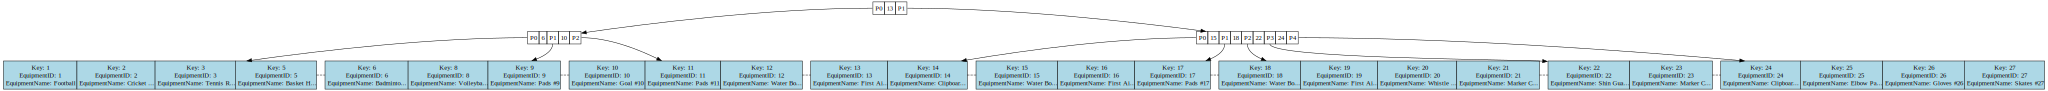

---

--- EquipmentLog Table (Loaded) ---

#### Loaded EquipmentLog B+ Tree

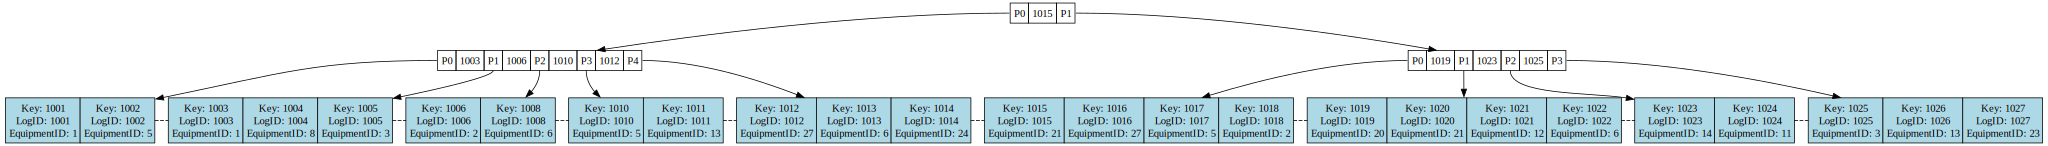

---

These should match the visualizations before saving.

### Search and Range Query on Loaded Data


Searching for EquipmentID = 15 in 'Equipment'...
  Found: {'EquipmentID': 15, 'EquipmentName': 'Water Bottles #15', 'IsAvailable': True, 'Condition_': 'Poor', 'LastCheckedDate': '2024-03-11'}

Performing Range Query on 'EquipmentLog' for LogID between 1008 and 1015...
  Found 2 records in range:
  - [{'LogID': 1008, 'EquipmentID': 6, 'IssuedTo': 502, 'IssueDate': '2024-04-14 10:30:00', 'ReturnDate': '2024-04-16 15:00:00'}, {'LogID': 1010, 'EquipmentID': 5, 'IssuedTo': 505, 'IssueDate': '2024-04-15 10:30:00', 'ReturnDate': '2024-04-16 15:00:00'}, {'LogID': 1011, 'EquipmentID': 13, 'IssuedTo': 504, 'IssueDate': '2024-04-15 11:36:00', 'ReturnDate': '2024-04-18 13:56:00'}, {'LogID': 1012, 'EquipmentID': 27, 'IssuedTo': 506, 'IssueDate': '2024-04-16 13:41:00', 'ReturnDate': '2024-04-17 16:09:00'}, {'LogID': 1013, 'EquipmentID': 6, 'IssuedTo': 504, 'IssueDate': '2024-04-17 11:02:00', 'ReturnDate': '2024-04-18 14:45:00'}, {'LogID': 1014, 'EquipmentID': 24, 'IssuedTo': 508, 'IssueDate': '2024

In [14]:
# --- Part 4: Visualize Loaded Trees and Perform Queries ---

# Get the loaded table instances
eq_table_loaded, success_eq = db_manager_load.get_table(DB_NAME, TABLE_EQ)
log_table_loaded, success_log = db_manager_load.get_table(DB_NAME, TABLE_LOG)
assert success_eq and success_log, "Failed to get loaded table instances"

# --- Visualize Loaded Trees ---
display(Markdown(f"### Visualization of Loaded Tables"))
if graphviz:
     display(Markdown(f"--- {TABLE_EQ} Table (Loaded) ---"))
     visualize_and_display(eq_table_loaded.data, f"Loaded {TABLE_EQ} B+ Tree")
     display(Markdown(f"--- {TABLE_LOG} Table (Loaded) ---"))
     visualize_and_display(log_table_loaded.data, f"Loaded {TABLE_LOG} B+ Tree")
else:
     print("Skipping visualizations.")
display(Markdown("These should match the visualizations before saving."))


# --- Query Loaded Data ---
display(Markdown("### Search and Range Query on Loaded Data"))

# --- Demonstrate Search (Equipment) ---
# Pick an ID likely to exist from the initial + generated data
search_id_eq = all_equipment_ids[len(all_equipment_ids) // 2] # Pick one from middle
print(f"\nSearching for EquipmentID = {search_id_eq} in '{TABLE_EQ}'...")
record_eq, found_eq = eq_table_loaded.get(search_id_eq)
if found_eq: print(f"  Found: {record_eq}")
else: print(f"  Record {search_id_eq} not found!")
assert found_eq, f"Search failed for existing Equipment key {search_id_eq}"

# --- Demonstrate Range Query (EquipmentLog) ---
# Find min/max LogID for a reasonable range
all_log_keys = sorted([rec["LogID"] for rec in all_log_data])
if len(all_log_keys) > 5:
     range_start = all_log_keys[len(all_log_keys) // 4] # Query middle range
     range_end = all_log_keys[len(all_log_keys) // 2]
else: # Fallback for very few records
     range_start = min(all_log_keys) if all_log_keys else 1000
     range_end = max(all_log_keys) if all_log_keys else 1010

print(f"\nPerforming Range Query on '{TABLE_LOG}' for LogID between {range_start} and {range_end}...")
results_list = log_table_loaded.range_query(range_start, range_end)
print(f"  Found {len(results_list)} records in range:")
if results_list:
    # Pretty print some results
    max_to_print = 5
    for i, res_rec in enumerate(results_list):
        print(f"  - {res_rec}")
        if i >= max_to_print - 1:
             if len(results_list) > max_to_print: print(f"  ... ({len(results_list) - max_to_print} more)")
             break
else: print("  (No records found in this specific range)")

print("\n--- Final Demonstration Complete ---")

## 3. Performance Analysis

This section analyzes the performance of the implemented B+ Tree against a simple Brute Force (list-based) approach. We measured the execution time for core operations (Insertion, Search, Update, Deletion, Range Query, Random Mix) and the peak memory usage during insertion. Tests were conducted for B+ Trees built with both unsorted (random) and sorted key insertion patterns across different data sizes, using B+ Tree orders of 10, 15, and 20.

In [19]:
# --- Configuration ---
ORDERS_TO_TEST = [10, 15, 20]
SIZES_TO_TEST = list(range(100, 100000, 5000)) 

# Parameters for specific tests (can be adjusted)
DELETE_PERCENTAGE_FOR_TEST = 20
MIX_OPS_FACTOR = 0.3
NUM_RANGE_QUERIES = 50

print(f"--- Benchmark Configuration ---")
print(f"Testing B+Tree Orders: {ORDERS_TO_TEST}")
print(f"Testing sizes: {SIZES_TO_TEST}")

# --- Initialization ---
analyzer = PerformanceAnalyzer()
all_insert_mem_results = []
all_search_results = []
all_range_results = []
all_delete_results = []
all_update_results = []
all_mix_results = []

print("\nSetup complete. Ready to run benchmark cells.")

--- Benchmark Configuration ---
Testing B+Tree Orders: [10, 15, 20]
Testing sizes: [100, 5100, 10100, 15100, 20100, 25100, 30100, 35100, 40100, 45100, 50100, 55100, 60100, 65100, 70100, 75100, 80100, 85100, 90100, 95100]

Setup complete. Ready to run benchmark cells.


In [20]:
def plot_time_comparison(df, y_unsorted, y_sorted, y_bf, title, y_label="Time (s)", use_log=True):
    plot_data = df.dropna(subset=[y_unsorted, y_sorted, y_bf])  # Ensure all data exists
    if plot_data.empty:
        print(f"Skipping plot '{title}': No valid data.")
        return

    plt.figure(figsize=(10, 5))
    grouped_plot = plot_data.groupby('order')

    # Custom color mapping by order
    color_map = {
        20: ('blue', '#4f8bd6'),   # dark blue, lighter blue
        15: ('green', '#6fcf97'),  # dark green, lighter green
        10: ('deeppink', '#ff8ecf')  # dark pink, lighter pink
    }

    for i, (order, group) in enumerate(grouped_plot):
        markers = ['o', 's', '^', 'd', 'v'] 
        marker = markers[i % len(markers)]
        color_dark, color_light = color_map.get(order, ('gray', 'lightgray'))  # default to gray if not specified

        plt.plot(group['size'], group[y_unsorted], marker=marker, linestyle='-', color=color_dark, label=f'B+U O={order}')
        plt.plot(group['size'], group[y_sorted], marker=marker, linestyle='--', color=color_light, label=f'B+S O={order}', alpha=0.9)

    # BF line: black solid with 'x' marker
    bf_group = plot_data.drop_duplicates(subset=['size'])
    plt.plot(bf_group['size'], bf_group[y_bf], marker='x', linestyle='-', color='black', label='BF')

    plt.xlabel("Records")
    plt.ylabel(y_label)
    plt.title(title)
    if use_log:
        plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()



--- Running Insertion & Peak Memory Benchmarks ---


Orders:   0%|          | 0/3 [00:00<?, ?it/s]

Order 10 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Ins/Mem Test (Size:100, Order:10)...
    Ins/Mem Test (Size:5100, Order:10)...
    Ins/Mem Test (Size:10100, Order:10)...
    Ins/Mem Test (Size:15100, Order:10)...
    Ins/Mem Test (Size:20100, Order:10)...
    Ins/Mem Test (Size:25100, Order:10)...
    Ins/Mem Test (Size:30100, Order:10)...
    Ins/Mem Test (Size:35100, Order:10)...
    Ins/Mem Test (Size:40100, Order:10)...
    Ins/Mem Test (Size:45100, Order:10)...
    Ins/Mem Test (Size:50100, Order:10)...
    Ins/Mem Test (Size:55100, Order:10)...
    Ins/Mem Test (Size:60100, Order:10)...
    Ins/Mem Test (Size:65100, Order:10)...
    Ins/Mem Test (Size:70100, Order:10)...
    Ins/Mem Test (Size:75100, Order:10)...
    Ins/Mem Test (Size:80100, Order:10)...
    Ins/Mem Test (Size:85100, Order:10)...
    Ins/Mem Test (Size:90100, Order:10)...
    Ins/Mem Test (Size:95100, Order:10)...


Order 15 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Ins/Mem Test (Size:100, Order:15)...
    Ins/Mem Test (Size:5100, Order:15)...
    Ins/Mem Test (Size:10100, Order:15)...
    Ins/Mem Test (Size:15100, Order:15)...
    Ins/Mem Test (Size:20100, Order:15)...
    Ins/Mem Test (Size:25100, Order:15)...
    Ins/Mem Test (Size:30100, Order:15)...
    Ins/Mem Test (Size:35100, Order:15)...
    Ins/Mem Test (Size:40100, Order:15)...
    Ins/Mem Test (Size:45100, Order:15)...
    Ins/Mem Test (Size:50100, Order:15)...
    Ins/Mem Test (Size:55100, Order:15)...
    Ins/Mem Test (Size:60100, Order:15)...
    Ins/Mem Test (Size:65100, Order:15)...
    Ins/Mem Test (Size:70100, Order:15)...
    Ins/Mem Test (Size:75100, Order:15)...
    Ins/Mem Test (Size:80100, Order:15)...
    Ins/Mem Test (Size:85100, Order:15)...
    Ins/Mem Test (Size:90100, Order:15)...
    Ins/Mem Test (Size:95100, Order:15)...


Order 20 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Ins/Mem Test (Size:100, Order:20)...
    Ins/Mem Test (Size:5100, Order:20)...
    Ins/Mem Test (Size:10100, Order:20)...
    Ins/Mem Test (Size:15100, Order:20)...
    Ins/Mem Test (Size:20100, Order:20)...
    Ins/Mem Test (Size:25100, Order:20)...
    Ins/Mem Test (Size:30100, Order:20)...
    Ins/Mem Test (Size:35100, Order:20)...
    Ins/Mem Test (Size:40100, Order:20)...
    Ins/Mem Test (Size:45100, Order:20)...
    Ins/Mem Test (Size:50100, Order:20)...
    Ins/Mem Test (Size:55100, Order:20)...
    Ins/Mem Test (Size:60100, Order:20)...
    Ins/Mem Test (Size:65100, Order:20)...
    Ins/Mem Test (Size:70100, Order:20)...
    Ins/Mem Test (Size:75100, Order:20)...
    Ins/Mem Test (Size:80100, Order:20)...
    Ins/Mem Test (Size:85100, Order:20)...
    Ins/Mem Test (Size:90100, Order:20)...
    Ins/Mem Test (Size:95100, Order:20)...

--- Insertion & Peak Memory Benchmarks Complete ---


**Insertion Time (s) & Peak Memory (MB) Results**

,order,size,bplus_insert_time_unsorted,bplus_insert_time_sorted,bf_insert_time,bplus_peak_mem_unsorted_MB,bplus_peak_mem_sorted_MB,bf_peak_mem_MB
0,10,100,0.0004,0.0003,0.0000,0.0057,0.0073,0.0009
1,10,5100,0.0125,0.0142,0.0060,0.3405,0.3605,0.3133
2,10,10100,0.0253,0.0254,0.0062,0.6643,0.7217,0.6213
3,10,15100,0.0424,0.0402,0.0106,0.9953,1.0789,0.9223
4,10,20100,0.1061,0.0499,0.0170,1.3295,1.4373,1.2397
5,10,25100,0.0905,0.0659,0.0200,1.6599,1.7959,1.5500
6,10,30100,0.1017,0.0922,0.0263,1.9914,2.1561,1.8430
7,10,35100,0.1462,0.2447,0.0289,2.3094,2.5140,2.1727
8,10,40100,0.1596,0.2073,0.0336,2.6565,2.8730,2.4764
9,10,45100,0.1710,0.2333,0.0381,2.9829,3.2306,2.7866


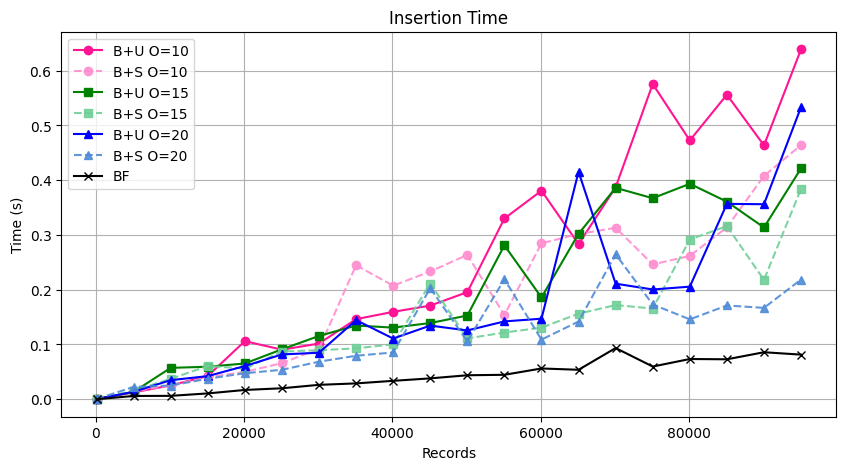

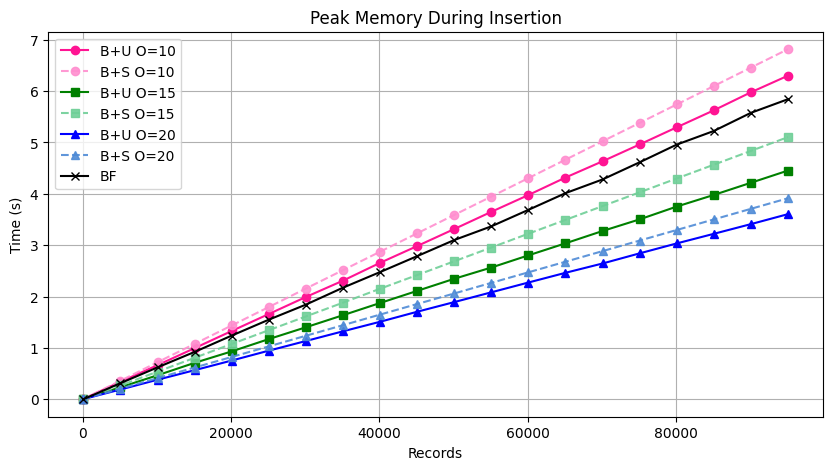

In [21]:
# Cell 2: Insertion and Peak Memory Test

print("\n--- Running Insertion & Peak Memory Benchmarks ---")
temp_results = []
for order in tqdm(ORDERS_TO_TEST, desc="Orders"):
    for size in tqdm(SIZES_TO_TEST, desc=f"Order {order} Sizes", leave=False):
        run_config = {'order': order, 'size': size}
        try:
            insert_mem_res = analyzer.run_insertion_memory_time_test(size, order)
            temp_results.append({**run_config, **insert_mem_res})
        except Exception as e:
            print(f"!! ERROR Ins/Mem: Size {size}, Order {order} failed: {type(e).__name__}: {e}")
            temp_results.append({**run_config, 'bf_insert_time': None, 'bf_peak_mem': None, # Add Nones
                                'bplus_insert_time_unsorted': None, 'bplus_peak_mem_unsorted': None,
                                'bplus_insert_time_sorted': None, 'bplus_peak_mem_sorted': None})
# Store results from this cell's run
all_insert_mem_results.extend(temp_results)
print("\n--- Insertion & Peak Memory Benchmarks Complete ---")

# --- Display Table for this cell ---
if all_insert_mem_results:
    df_insert_mem_partial = pd.DataFrame(all_insert_mem_results).fillna(np.nan)
    # Convert mem to MB
    mem_cols = ['bf_peak_mem', 'bplus_peak_mem_unsorted', 'bplus_peak_mem_sorted']
    for col in mem_cols:
        if col in df_insert_mem_partial.columns: df_insert_mem_partial[f'{col}_MB'] = df_insert_mem_partial[col] / (1024*1024)
    # Define cols to show
    insert_cols_disp = ['order', 'size', 'bplus_insert_time_unsorted', 'bplus_insert_time_sorted', 'bf_insert_time',
                        'bplus_peak_mem_unsorted_MB', 'bplus_peak_mem_sorted_MB', 'bf_peak_mem_MB']
    insert_cols_disp = [c for c in insert_cols_disp if c in df_insert_mem_partial.columns]
    display(Markdown("**Insertion Time (s) & Peak Memory (MB) Results**"))
    display(df_insert_mem_partial[insert_cols_disp].round(4))
else:
    print("No insertion/memory results generated.")
    
# 1. Insertion Time Plot
plot_time_comparison(df_insert_mem_partial, 'bplus_insert_time_unsorted', 'bplus_insert_time_sorted', 'bf_insert_time', 'Insertion Time', use_log=False)

plot_time_comparison(df_insert_mem_partial, 'bplus_peak_mem_unsorted_MB', 'bplus_peak_mem_sorted_MB', 'bf_peak_mem_MB', 'Peak Memory During Insertion', use_log=False)

### Insertion Performance Observations

*   **Time:**
    *   The Brute Force (list append) consistently demonstrated the fastest insertion times, aligning with its O(1) average time complexity per operation (O(N) total).
    *   B+ Tree insertion (both sorted and unsorted) was slower due to the overhead of node traversal (O(log N)) and potential node splitting/rebalancing. No clear time advantage was observed between sorted and unsorted B+ Tree insertion in this specific test run; Python overhead and specific split patterns likely influenced the results.
*   **Peak Memory:**
    *   Brute Force exhibited the lowest peak memory usage, reflecting simple list allocation.
    *   B+ Trees required significantly more peak memory due to node structures, keys, pointers, and temporary objects during splits.
    *   **Sorted B+ Tree insertion consistently used slightly more peak memory** than unsorted insertion across tested orders. This is likely because predictable splits on full nodes can lead to lower average node utilization during the build process compared to random insertions.
*   **Order Impact:** Larger B+ Tree orders generally resulted in lower peak memory usage (fewer nodes/less structural overhead). The effect on insertion time was less consistent.



--- Running Search Time Benchmarks ---


Orders:   0%|          | 0/3 [00:00<?, ?it/s]

Order 10 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Search Test (Size:100, Order:10)...
    Search Test (Size:5100, Order:10)...
    Search Test (Size:10100, Order:10)...
    Search Test (Size:15100, Order:10)...
    Search Test (Size:20100, Order:10)...
    Search Test (Size:25100, Order:10)...
    Search Test (Size:30100, Order:10)...
    Search Test (Size:35100, Order:10)...
    Search Test (Size:40100, Order:10)...
    Search Test (Size:45100, Order:10)...
    Search Test (Size:50100, Order:10)...
    Search Test (Size:55100, Order:10)...
    Search Test (Size:60100, Order:10)...
    Search Test (Size:65100, Order:10)...
    Search Test (Size:70100, Order:10)...
    Search Test (Size:75100, Order:10)...
    Search Test (Size:80100, Order:10)...
    Search Test (Size:85100, Order:10)...
    Search Test (Size:90100, Order:10)...
    Search Test (Size:95100, Order:10)...


Order 15 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Search Test (Size:100, Order:15)...
    Search Test (Size:5100, Order:15)...
    Search Test (Size:10100, Order:15)...
    Search Test (Size:15100, Order:15)...
    Search Test (Size:20100, Order:15)...
    Search Test (Size:25100, Order:15)...
    Search Test (Size:30100, Order:15)...
    Search Test (Size:35100, Order:15)...
    Search Test (Size:40100, Order:15)...
    Search Test (Size:45100, Order:15)...
    Search Test (Size:50100, Order:15)...
    Search Test (Size:55100, Order:15)...
    Search Test (Size:60100, Order:15)...
    Search Test (Size:65100, Order:15)...
    Search Test (Size:70100, Order:15)...
    Search Test (Size:75100, Order:15)...
    Search Test (Size:80100, Order:15)...
    Search Test (Size:85100, Order:15)...
    Search Test (Size:90100, Order:15)...
    Search Test (Size:95100, Order:15)...


Order 20 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Search Test (Size:100, Order:20)...
    Search Test (Size:5100, Order:20)...
    Search Test (Size:10100, Order:20)...
    Search Test (Size:15100, Order:20)...
    Search Test (Size:20100, Order:20)...
    Search Test (Size:25100, Order:20)...
    Search Test (Size:30100, Order:20)...
    Search Test (Size:35100, Order:20)...
    Search Test (Size:40100, Order:20)...
    Search Test (Size:45100, Order:20)...
    Search Test (Size:50100, Order:20)...
    Search Test (Size:55100, Order:20)...
    Search Test (Size:60100, Order:20)...
    Search Test (Size:65100, Order:20)...
    Search Test (Size:70100, Order:20)...
    Search Test (Size:75100, Order:20)...
    Search Test (Size:80100, Order:20)...
    Search Test (Size:85100, Order:20)...
    Search Test (Size:90100, Order:20)...
    Search Test (Size:95100, Order:20)...

--- Search Time Benchmarks Complete ---


**Search Time (s) Results**

,order,size,bplus_search_time_unsorted,bplus_search_time_sorted,bf_search_time
0,10,100,0.0001,0.0001,0.0002
1,10,5100,0.0005,0.0005,0.0383
2,10,10100,0.0012,0.0011,0.1608
3,10,15100,0.0016,0.0018,0.4998
4,10,20100,0.0030,0.0027,0.8690
5,10,25100,0.0032,0.0039,1.8512
6,10,30100,0.0060,0.0078,2.5609
7,10,35100,0.0064,0.0053,3.6332
8,10,40100,0.0085,0.0062,4.4122
9,10,45100,0.0104,0.0069,6.5179


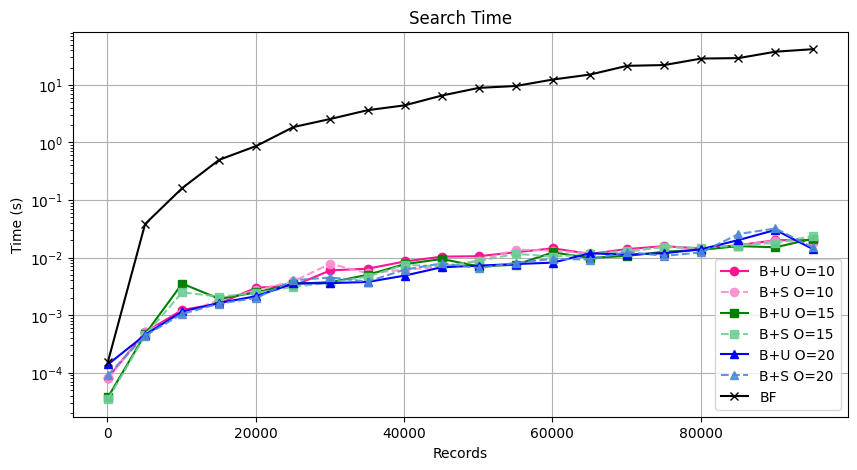

In [22]:
# Cell 3: Search Test

print("\n--- Running Search Time Benchmarks ---")
temp_results = []
for order in tqdm(ORDERS_TO_TEST, desc="Orders"):
    for size in tqdm(SIZES_TO_TEST, desc=f"Order {order} Sizes", leave=False):
        run_config = {'order': order, 'size': size}
        try:
            search_res = analyzer.run_search_test(size, order)
            temp_results.append({**run_config, **search_res})
        except Exception as e:
            print(f"!! ERROR Search: Size {size}, Order {order} failed: {type(e).__name__}: {e}")
            temp_results.append({**run_config, 'bplus_search_time_unsorted': None, # Add Nones
                                'bplus_search_time_sorted': None, 'bf_search_time': None})
# Store results from this cell's run
all_search_results.extend(temp_results)
print("\n--- Search Time Benchmarks Complete ---")

# --- Display Table for this cell ---
if all_search_results:
     df_search_partial = pd.DataFrame(all_search_results).fillna(np.nan)
     search_cols_disp = ['order', 'size', 'bplus_search_time_unsorted', 'bplus_search_time_sorted', 'bf_search_time']
     search_cols_disp = [c for c in search_cols_disp if c in df_search_partial.columns]
     display(Markdown("**Search Time (s) Results**"))
     display(df_search_partial[search_cols_disp].round(4))
else:
    print("No search results generated.")
    
plot_time_comparison(df_search_partial, 'bplus_search_time_unsorted', 'bplus_search_time_sorted', 'bf_search_time', 'Search Time')

### Search Performance Observations

*   **Time Complexity:**
    *   Brute Force search time increased linearly (O(N)) with data size, becoming very slow.
    *   Both B+ Tree variants showed significantly faster search times with much slower growth, consistent with O(log N) complexity.
*   **Sorted vs. Unsorted Build:** No significant difference in search time was observed between trees built with sorted vs. unsorted data. Both benefit equally from the final balanced structure.
*   **Order Impact:** All tested B+ Tree orders provided massive improvements over Brute Force, with no single order showing a definitive advantage in this run.

In [23]:
# Cell 4: Range Query Test

print("\n--- Running Range Query Time Benchmarks ---")
temp_results = []
for order in tqdm(ORDERS_TO_TEST, desc="Orders"):
    for size in tqdm(SIZES_TO_TEST, desc=f"Order {order} Sizes", leave=False):
        run_config = {'order': order, 'size': size}
        try:
            range_res = analyzer.run_range_query_test(size, order, num_queries=NUM_RANGE_QUERIES)
            temp_results.append({**run_config, **range_res})
        except Exception as e:
            print(f"!! ERROR Range: Size {size}, Order {order} failed: {type(e).__name__}: {e}")
            temp_results.append({**run_config, 'bplus_range_time_unsorted': None, # Add Nones
                                'bplus_range_time_sorted': None, 'bf_range_time': None})
# Store results from this cell's run
all_range_results.extend(temp_results)
print("\n--- Range Query Time Benchmarks Complete ---")

# --- Display Table for this cell ---
if all_range_results:
     df_range_partial = pd.DataFrame(all_range_results).fillna(np.nan)
     range_cols_disp = ['order', 'size', 'bplus_range_time_unsorted', 'bplus_range_time_sorted', 'bf_range_time']
     range_cols_disp = [c for c in range_cols_disp if c in df_range_partial.columns]
     display(Markdown("**Range Query Time (s) Results**"))
     display(df_range_partial[range_cols_disp].round(4))
else:
    print("No range query results generated.")
    
plot_time_comparison(df_range_partial, 'bplus_range_time_unsorted', 'bplus_range_time_sorted', 'bf_range_time', 'Range Query Time')


--- Running Range Query Time Benchmarks ---


Orders:   0%|          | 0/3 [00:00<?, ?it/s]

Order 10 Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

    Range Test (Size:100, Order:10)...
    Range Test (Size:5100, Order:10)...


KeyboardInterrupt: 

### Range Query Performance Observations

*   **Time Complexity:**
    *   Brute Force time increased linearly (O(N)) as it scans the entire dataset.
    *   B+ Tree time was significantly better, primarily dependent on finding the start leaf (O(log N)) and scanning relevant leaves (+k). This O(log N + k) complexity is far superior when the range `k` is smaller than the total data size `N`.
*   **Sorted vs. Unsorted Build:** Both B+ Tree build methods performed similarly well, effectively utilizing the linked-leaf structure.
*   **Order Impact:** All B+ Tree orders significantly outperformed Brute Force, with no consistent winner among the tested orders.


--- Running Deletion Time Benchmarks ---


Orders:   0%|          | 0/3 [00:00<?, ?it/s]

Order 10 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Delete Test (Size:100, Order:10)...
    Delete Test (Size:10100, Order:10)...
    Delete Test (Size:20100, Order:10)...
    Delete Test (Size:30100, Order:10)...
    Delete Test (Size:40100, Order:10)...


Order 15 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Delete Test (Size:100, Order:15)...
    Delete Test (Size:10100, Order:15)...
    Delete Test (Size:20100, Order:15)...
    Delete Test (Size:30100, Order:15)...
    Delete Test (Size:40100, Order:15)...


Order 20 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Delete Test (Size:100, Order:20)...
    Delete Test (Size:10100, Order:20)...
    Delete Test (Size:20100, Order:20)...
    Delete Test (Size:30100, Order:20)...
    Delete Test (Size:40100, Order:20)...

--- Deletion Time Benchmarks Complete ---


**Deletion Time (s) Results**

,order,size,bplus_delete_time_unsorted,bplus_delete_time_sorted,bf_delete_time
0,10,100,0.0001,0.0001,0.0001
1,10,10100,0.0327,0.0205,0.9794
2,10,20100,0.0061,0.0069,3.5785
3,10,30100,0.0137,0.0132,13.8091
4,10,40100,0.0529,0.0389,32.7801
5,15,100,0.0000,0.0000,0.0001
6,15,10100,0.0106,0.0133,1.2277
7,15,20100,0.0110,0.0173,6.4520
8,15,30100,0.0243,0.0291,17.9210
9,15,40100,0.0535,0.0720,23.3922


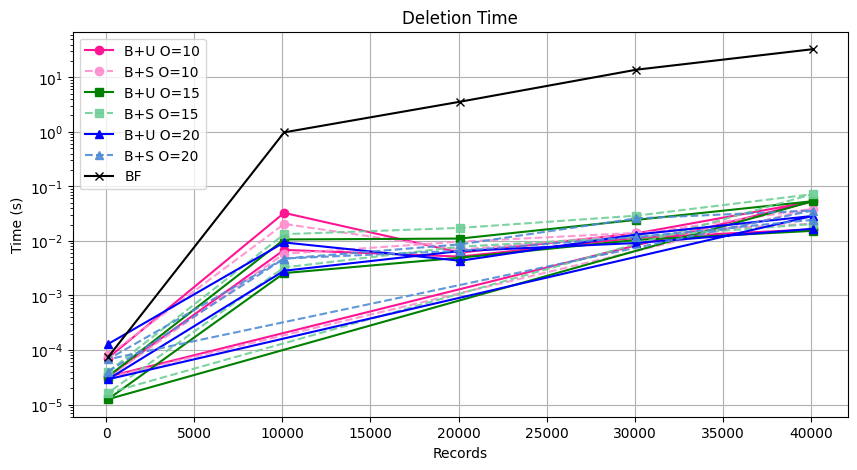

In [ ]:
# Cell 5: Deletion Test

print("\n--- Running Deletion Time Benchmarks ---")
# Note: This test in the analyzer also calculates post-delete memory,
# but we primarily focus on time for this plot/table as per requirement focus shift.
temp_results = []
for order in tqdm(ORDERS_TO_TEST, desc="Orders"):
    for size in tqdm(SIZES_TO_TEST, desc=f"Order {order} Sizes", leave=False):
        run_config = {'order': order, 'size': size}
        try:
            delete_res = analyzer.run_delete_test(size, order, delete_percentage=DELETE_PERCENTAGE_FOR_TEST)
            temp_results.append({**run_config, **delete_res})
        except Exception as e:
            print(f"!! ERROR Delete: Size {size}, Order {order} failed: {type(e).__name__}: {e}")
            temp_results.append({**run_config, 'bplus_delete_time_unsorted': None, # Add Nones
                                'bplus_delete_time_sorted': None, 'bf_delete_time': None})
# Store results from this cell's run
all_delete_results.extend(temp_results)
print("\n--- Deletion Time Benchmarks Complete ---")

# --- Display Table for this cell ---
if all_delete_results:
     df_delete_partial = pd.DataFrame(all_delete_results).fillna(np.nan)
     delete_cols_disp = ['order', 'size', 'bplus_delete_time_unsorted', 'bplus_delete_time_sorted', 'bf_delete_time']
     delete_cols_disp = [c for c in delete_cols_disp if c in df_delete_partial.columns]
     display(Markdown("**Deletion Time (s) Results**"))
     display(df_delete_partial[delete_cols_disp].round(4))
else:
    print("No delete results generated.")
    
plot_time_comparison(df_delete_partial, 'bplus_delete_time_unsorted', 'bplus_delete_time_sorted', 'bf_delete_time', 'Deletion Time')

### Deletion Performance Observations

*   **Time Complexity:**
    *   Brute Force deletion time increased dramatically (O(N)) due to the need to find the element and potentially shift remaining elements.
    *   B+ Tree deletion scaled much better, reflecting the O(log N) complexity for finding the element and logarithmic average time for rebalancing (borrow/merge).
*   **Sorted vs. Unsorted Build:** No consistent difference in deletion time was observed based on the initial build method.
*   **Order Impact:** All B+ Tree orders were vastly superior to Brute Force for deletions.


--- Running Update Time Benchmarks ---


Orders:   0%|          | 0/3 [00:00<?, ?it/s]

Order 10 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Update Test (Size:100, Order:10)...
    Update Test (Size:10100, Order:10)...
    Update Test (Size:20100, Order:10)...
    Update Test (Size:30100, Order:10)...
    Update Test (Size:40100, Order:10)...


Order 15 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Update Test (Size:100, Order:15)...
    Update Test (Size:10100, Order:15)...
    Update Test (Size:20100, Order:15)...
    Update Test (Size:30100, Order:15)...
    Update Test (Size:40100, Order:15)...


Order 20 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Update Test (Size:100, Order:20)...
    Update Test (Size:10100, Order:20)...
    Update Test (Size:20100, Order:20)...
    Update Test (Size:30100, Order:20)...
    Update Test (Size:40100, Order:20)...

--- Update Time Benchmarks Complete ---


**Update Time (s) Results**

,order,size,bplus_update_time_unsorted,bplus_update_time_sorted,bf_update_time
0,10,100,0.0001,0.0001,0.0003
1,10,10100,0.0014,0.0014,0.3036
2,10,20100,0.0023,0.0025,1.6486
3,10,30100,0.0042,0.0045,4.3395
4,10,40100,0.0094,0.0142,10.1397
5,15,100,0.0001,0.0001,0.0004
6,15,10100,0.0021,0.0023,0.5501
7,15,20100,0.0044,0.0039,2.5129
8,15,30100,0.0060,0.0060,7.8156
9,15,40100,0.0076,0.0083,8.7941


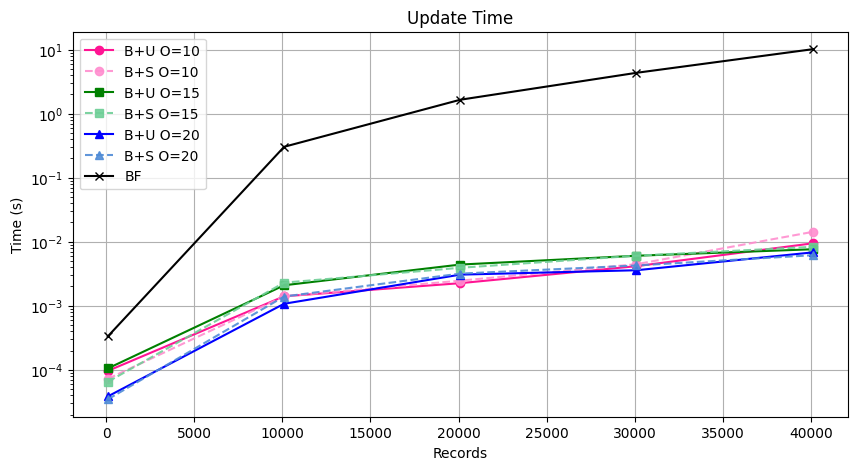

In [ ]:
# Cell 6: Update Test

print("\n--- Running Update Time Benchmarks ---")
temp_results = []
for order in tqdm(ORDERS_TO_TEST, desc="Orders"):
    for size in tqdm(SIZES_TO_TEST, desc=f"Order {order} Sizes", leave=False):
        run_config = {'order': order, 'size': size}
        try:
            update_res = analyzer.run_update_test(size, order)
            temp_results.append({**run_config, **update_res})
        except Exception as e:
            print(f"!! ERROR Update: Size {size}, Order {order} failed: {type(e).__name__}: {e}")
            temp_results.append({**run_config, 'bplus_update_time_unsorted': None, # Add Nones
                                'bplus_update_time_sorted': None, 'bf_update_time': None})
# Store results from this cell's run
all_update_results.extend(temp_results)
print("\n--- Update Time Benchmarks Complete ---")

# --- Display Table for this cell ---
if all_update_results:
     df_update_partial = pd.DataFrame(all_update_results).fillna(np.nan)
     update_cols_disp = ['order', 'size', 'bplus_update_time_unsorted', 'bplus_update_time_sorted', 'bf_update_time']
     update_cols_disp = [c for c in update_cols_disp if c in df_update_partial.columns]
     display(Markdown("**Update Time (s) Results**"))
     display(df_update_partial[update_cols_disp].round(4))
else:
    print("No update results generated.")
    
plot_time_comparison(df_update_partial, 'bplus_update_time_unsorted', 'bplus_update_time_sorted', 'bf_update_time', 'Update Time')

### Update Performance Observations

*   **Time Complexity:**
    *   Brute Force update time scaled linearly (O(N)) due to the initial search required.
    *   B+ Tree update time scaled logarithmically (O(log N)), involving only finding the leaf and modifying the value in place.
*   **Sorted vs. Unsorted Build:** No significant difference in update performance was noted based on the initial insertion order.
*   **Order Impact:** All tested B+ Tree orders significantly outperformed Brute Force.


--- Running Random Mix Time Benchmarks ---


Orders:   0%|          | 0/3 [00:00<?, ?it/s]

Order 10 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Mix Test (Size:100, Order:10)...
      Mix (B+U/B+S/BF): 0.0001s / 0.0001s / 0.0001s
    Mix Test (Size:10100, Order:10)...
      Mix (B+U/B+S/BF): 0.0067s / 0.0056s / 1.0235s
    Mix Test (Size:20100, Order:10)...
      Mix (B+U/B+S/BF): 0.0100s / 0.0082s / 3.4377s
    Mix Test (Size:30100, Order:10)...
      Mix (B+U/B+S/BF): 0.0212s / 0.0205s / 10.7769s
    Mix Test (Size:40100, Order:10)...
      Mix (B+U/B+S/BF): 0.0514s / 0.0413s / 26.7019s


Order 15 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Mix Test (Size:100, Order:15)...
      Mix (B+U/B+S/BF): 0.0000s / 0.0001s / 0.0001s
    Mix Test (Size:10100, Order:15)...
      Mix (B+U/B+S/BF): 0.0063s / 0.0089s / 1.1672s
    Mix Test (Size:20100, Order:15)...
      Mix (B+U/B+S/BF): 0.0113s / 0.0099s / 3.6702s
    Mix Test (Size:30100, Order:15)...
      Mix (B+U/B+S/BF): 0.0149s / 0.0214s / 9.3582s
    Mix Test (Size:40100, Order:15)...
      Mix (B+U/B+S/BF): 0.0253s / 0.0270s / 19.8499s


Order 20 Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

    Mix Test (Size:100, Order:20)...
      Mix (B+U/B+S/BF): 0.0001s / 0.0001s / 0.0001s
    Mix Test (Size:10100, Order:20)...
      Mix (B+U/B+S/BF): 0.0062s / 0.0072s / 1.3742s
    Mix Test (Size:20100, Order:20)...
      Mix (B+U/B+S/BF): 0.0169s / 0.0148s / 5.4779s
    Mix Test (Size:30100, Order:20)...
      Mix (B+U/B+S/BF): 0.0135s / 0.0144s / 8.2431s
    Mix Test (Size:40100, Order:20)...
      Mix (B+U/B+S/BF): 0.0299s / 0.0342s / 25.6880s

--- Random Mix Time Benchmarks Complete ---


**Random Mix Time (s) Results**

,order,size,bplus_mix_time_unsorted,bplus_mix_time_sorted,bf_mix_time
0,10,100,0.0001,0.0001,0.0001
1,10,10100,0.0067,0.0056,1.0235
2,10,20100,0.0100,0.0082,3.4377
3,10,30100,0.0212,0.0205,10.7769
4,10,40100,0.0514,0.0413,26.7019
5,15,100,0.0000,0.0001,0.0001
6,15,10100,0.0063,0.0089,1.1672
7,15,20100,0.0113,0.0099,3.6702
8,15,30100,0.0149,0.0214,9.3582
9,15,40100,0.0253,0.0270,19.8499


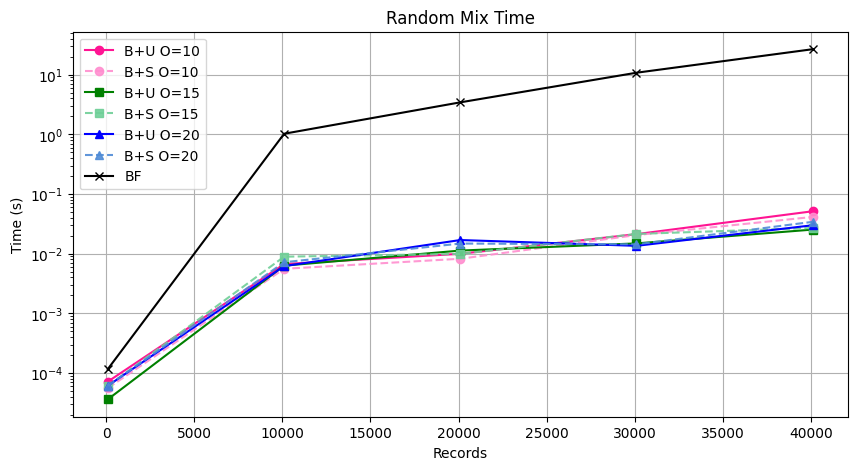

In [ ]:
# Cell 7: Random Mix Test

print("\n--- Running Random Mix Time Benchmarks ---")
temp_results = []
for order in tqdm(ORDERS_TO_TEST, desc="Orders"):
    for size in tqdm(SIZES_TO_TEST, desc=f"Order {order} Sizes", leave=False):
        run_config = {'order': order, 'size': size}
        try:
            mix_res = analyzer.run_random_mix_test(size, order, num_operations_factor=MIX_OPS_FACTOR)
            temp_results.append({**run_config, **mix_res})
        except Exception as e:
            print(f"!! ERROR Mix: Size {size}, Order {order} failed: {type(e).__name__}: {e}")
            temp_results.append({**run_config, 'bplus_mix_time_unsorted': None, # Add Nones
                                'bplus_mix_time_sorted': None, 'bf_mix_time': None})
# Store results from this cell's run
all_mix_results.extend(temp_results)
print("\n--- Random Mix Time Benchmarks Complete ---")

# --- Display Table for this cell ---
if all_mix_results:
     df_mix_partial = pd.DataFrame(all_mix_results).fillna(np.nan)
     mix_cols_disp = ['order', 'size', 'bplus_mix_time_unsorted', 'bplus_mix_time_sorted', 'bf_mix_time']
     mix_cols_disp = [c for c in mix_cols_disp if c in df_mix_partial.columns]
     display(Markdown("**Random Mix Time (s) Results**"))
     display(df_mix_partial[mix_cols_disp].round(4))
else:
    print("No mix results generated.")
    
plot_time_comparison(df_mix_partial, 'bplus_mix_time_unsorted', 'bplus_mix_time_sorted', 'bf_mix_time', 'Random Mix Time')

### Random Mix Performance Observations

*   **Time Complexity:**
    *   Brute Force performance degraded rapidly under the mixed workload due to its expensive search, delete, and update operations.
    *   Both B+ Tree variants handled the mixed workload much more efficiently and scaled significantly better, benefiting from the logarithmic complexity of all their core operations.
*   **Sorted vs. Unsorted Build:** No notable performance difference was seen between the B+ Tree build types under this mixed workload.
*   **Order Impact:** All B+ Tree orders performed substantially better than Brute Force, with no single order showing consistent superiority.

## 5. Conclusion

This report covers the **demonstrations of the operations** (i.e insert, delete) facilited by the B+Tree class created includign the edge cases. 

We have also validated the correctness of our B+ Tree algorithm and demonstrated 2 tables **persistance** from our database.

### Key Takeaway of the Performance Analysis 

**Insertion:** B+ Tree insertion incurs time and memory overhead to build its index, with sorted insertion potentially leading to higher peak memory usage than unsorted insertion. Brute force is superior for pure, blind insertion speed and peak memory.

**Search:** The B+ Tree offers a dramatic performance advantage for exact-match searches over linear scans, scaling logarithmically compared to the linear scaling of Brute Force.

**Range Query:** The B+ Tree's linked-leaf structure is highly efficient for range queries compared to Brute Force's full scan.

**Deletion:** The B+ Tree's structure allows for significantly more efficient deletion than a simple list, especially at scale.

**Update:** The B+ Tree's efficient search makes record updates based on the key much faster than the Brute Force approach.

**Random Mix:** The B+ Tree demonstrates robust and scalable performance for realistic mixed workloads involving various operations, highlighting its suitability for general data management compared to the inefficient Brute Force list.